# 인구 소득 예측 경진대회

## 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
sns.set_theme()

In [338]:
SEED = 22

In [339]:
os.chdir('C:\\Users\\Jaesu\\github_desktop\\Dacon-Basic\\인구-소득-예측')

In [395]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

|변수 이름 |세부 사항 |
|:-:|:-:|
|id | 샘플 아이디|
|age | 나이|
|workclass | 일 유형|
|fnlwgt | CPS(Current Population Survey) 가중치|
|education | 교육수준|
|education.num | 교육수준 번호(클수록 높은 학위)|
|marital.status | 결혼 상태|
|occupation| 직업|
|relationship | 가족관계|
|race | 인종|
|sex |성별|
|capital.gain | 자본 이익|
|capital.loss | 자본 손실|
|hours.per.week |주당 근무시간|
|native.country | 본 국적|
|target | 소득(0: <=50K, 1: >50K)|

In [396]:
df.isnull().sum()

id                   0
age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
target               0
dtype: int64

`-` `workclass`, `occupation`, `native.country` 변수에 결측치가 존재한다

## 데이터 전처리

`-` 분석의 편의성을 위해 변수명의 `.`을 `_`으로 바꾸겠다

In [397]:
def replace_dot2underbar(df) -> None:
    """데이터프레임의 변수명에 포함된 .(dot)을 _(underbar)로 변경한다"""
    df.rename(columns = dict(zip(df.columns, [column.replace('.', '_') for column in df.columns])), inplace=True) 

In [398]:
replace_dot2underbar(df)

In [399]:
replace_dot2underbar(test)

In [400]:
df.columns

Index(['id', 'age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'target'],
      dtype='object')

`-` 잘 바뀌었다

`-` 이제 변수 타입을 확인하자

In [378]:
df.dtypes

id                 int64
age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
target             int64
dtype: object

`-` 상식에 벗어나는 타입을 가진 변수는 없다

In [401]:
df['target'] = df['target'].map({1:'>50K', 0:'<=50K'})

`-` 시각화를 위해 target의 범주명을 바꾸겠다

`-` 오브젝트 타입 변수의 유니크한 값의 개수를 확인하자

`-` 범주형 변수를 카테고리 타입으로 바꿔주겠다

In [380]:
def category2str(df) -> None:
    ## 아래는 시각화의 편의를 위해서임
    for feature in df.columns[(df.dtypes == 'category')]:
        df[feature] = df[feature].astype('str')

In [381]:
def str2category(df) -> None:
    ## 교육수준이 낮은 것부터 높은 순으로 order를 정한다
    df['education'] = pd.Categorical(df['education'], ['Preschool',
                                                       '1st-4th',
                                                       '5th-6th',
                                                       '7th-8th',
                                                       '9th',
                                                       '10th',
                                                       '11th',
                                                       '12th',
                                                       'HS-grad',
                                                       'Some-college',
                                                       'Assoc-voc',
                                                       'Assoc-acdm',
                                                       'Bachelors',
                                                       'Masters',
                                                       'Prof-school',
                                                       'Doctorate'])
    
    ## 아래는 시각화의 편의를 위해서임
    for feature in df.columns[(df.dtypes == 'object')]:
        df[feature] = pd.Categorical(df[feature], df[feature].value_counts().index)

In [402]:
str2category(df)

## EDA

### 범주형 변수 시각화

In [15]:
def show_unique_counts(df_: pd.DataFrame, target: str) -> None:
    """ df의 변수 중에서 범주형 변수의 unique한 값의 개수를 시각화하는 함수"""
    df = df_.copy()
    df = df.dropna() ## 결측치 제거
    ## len(df.columns[(df.dtypes == 'object') | (df.dtypes == 'category')])의 결과를 보고 적절한 shape을 수동으로 지정해야 한다
    ## 결과값이 9이므로 5 X 2 크기의 figure를 만들자
    row, column = 5, 2
    fig, axs = plt.subplots(row, column, figsize=(16, 40))
    features = df.columns[(df.dtypes == 'object') | (df.dtypes == 'category')]
    
    for i, feature in enumerate(features):
        ax = axs[i // column][i % column]
        order = df_[feature].sort_values().unique() ## dropna() 때문에 사라진 범주가 있어서 삭제 전의 df_를 기준으로 order를 만듦
        gg = sns.histplot(data=df, y=feature, hue=target, multiple='stack', shrink=0.8, discrete=True, ax=ax)
        max_width = max([p.get_width() for p in gg.patches]) 
        sns.move_legend(gg, 'lower right', title='income')

        for j, p in enumerate(gg.patches):
            try:
                condition = f'{feature} == "{order[j]}"'
                aa = df.query(condition)['target'].value_counts()
                text = np.round((100 * aa.to_dict().pop('>50K', 0) / sum(aa)), 2) ## text => (>50K) / (<=50K + >50K)
                gg.annotate('{:.2f}%'.format(text), (p.get_width() + 0.05*max_width, p.get_y() + 0.5*p.get_height() + 0.06)) ## text의 위치 조정
            except:
                pass
    
    ## 남는 서브 플랏은 삭제하자
    for ax in axs: ## axs의 row
        for k in [0, 1]: ## axs의 column
            if not ax[k].containers: ## ax[k]에 bar 그래프(오브젝트)가 그려져있지 않다면(비어있다면) ## containers는 막대가 있는 그래프일 때만 쓸 수 있고 그 외는 has_data()를 쓰자
                fig.delaxes(ax[k]) ## 남는 서브 플랏이니 삭제한다

    fig.suptitle("Categorical feature's Unique Counts\n\n", x=0.56, fontsize=25) ## default: x=0.5, y=0.98
    fig.tight_layout()

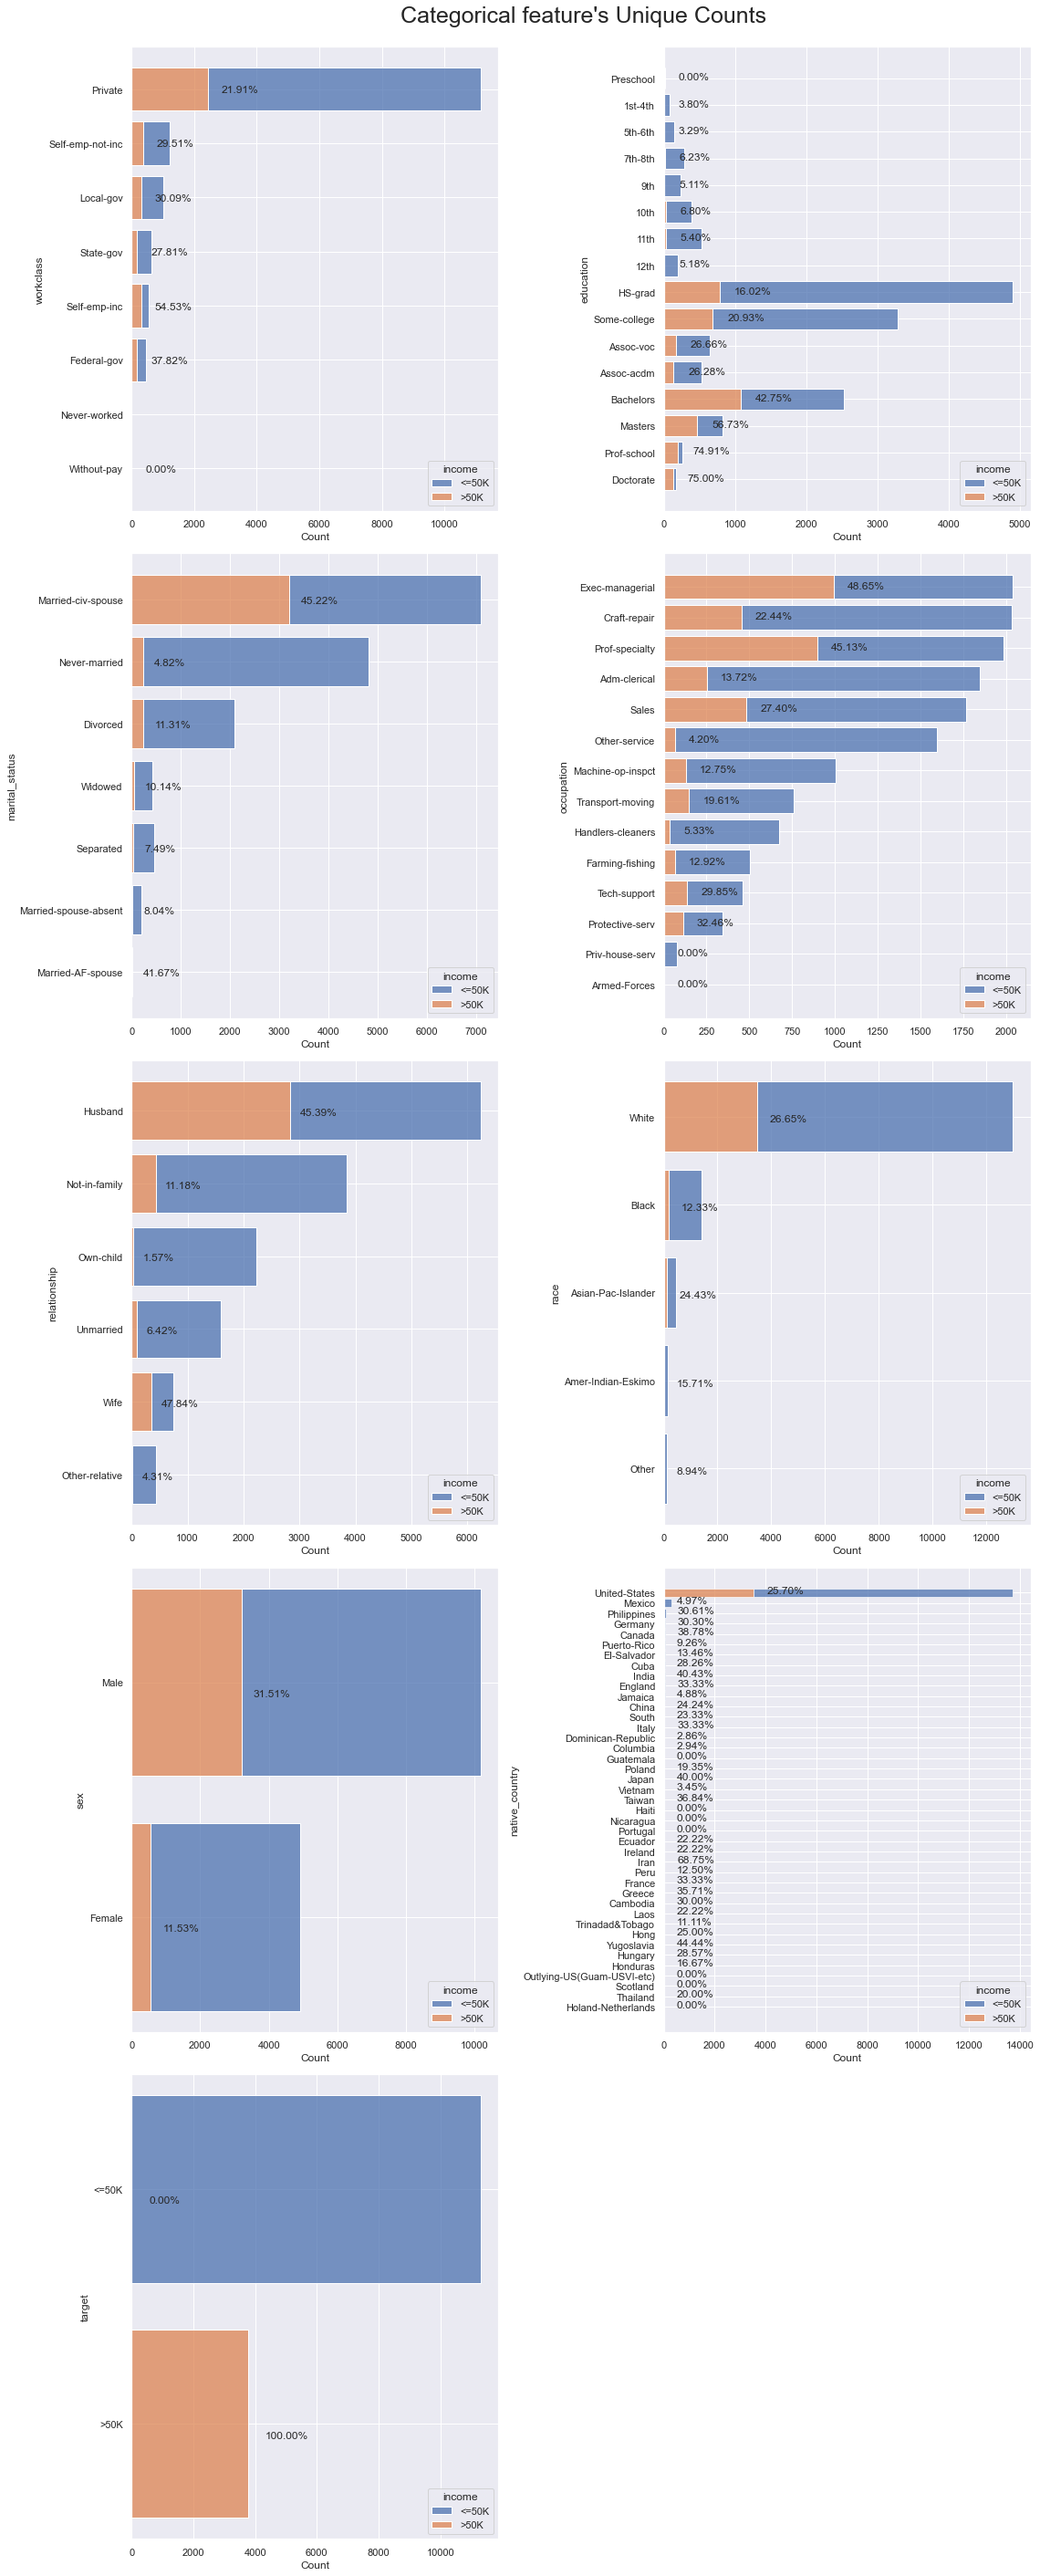

In [16]:
show_unique_counts(df, 'target')

`-` workclass에서 Never-worked 범주는 text가 없는데 결측치를 드랍하면 해당 범주에 속한 값이 없기 때문이다

`-` 미국인 대상으로 조사한 거라 `native_country` 변수의 대부분이 United-States이다

`-` 3개 범주정도만 막대그래프가 보이고 나머지는 상대적으로 너무 적은 나머지 보이지도 않는다...

`-` 나중에 수치로 변환할 때 `Other`로 인코딩하는 것을 고려하자

`-` 소득 범주인 `>50K`과 `<=50K`의 비율 차이가 많이 나는 피쳐의 범주가 존재한다(예컨대 교육번호 피쳐의 Doctorate) 

`-` 소득이 50K보다 작은 사람이 50K보다 많은 사람의 3배이다(불균형 클래스)

- 직업이 결측치인 경우

`-` 직업이 결측치인 경우는 사실 직업이 없는게 아닐까? 

`-` workclass에서 Without-pay는 직업이 없는게 아니라 돈을 안받는 직업같다(근데 돈을 받아야 직업 아닌가?...)

`-` 근데 직업이 없다기에는 hours_per_week가 0이 아니다

`-` 사실 hours_per_week 변수도 많이 이상한데 1살~4살인 애기들도 $0$이 아니며 중앙값이 $40$ 부근이다

`-` 두 가지 경우 중 하나일 것 같은데 하나는 사실 hours_per_week 변수가 일하는 시간만 포함하는 것이 아닌 다른 무언가도 포함하는 것과

`-` 1살~4살 애기들은 본인이 직접 설문조사에 참여를 못하니 부모님이 대신 작성해서 부모님의 근로 시간이 입력됐다는 것이다

`-` 근데 후자라고 하기 이상한게 11살~12살이면 본인이 직접 설문조사에 참여할 수 있을텐데 근로 시간의 분포가 어른들과 비슷하다는 것이다(11살부터 아르바이트??) 

`-` 둘다 아니면 범주에 속하지 않는 직업이라 생각하는 것이 나을 수 있다

In [684]:
df[(df['occupation'].isnull()) & (df['workclass'].isnull())].target.value_counts()

<=50K    1645
>50K      191
Name: target, dtype: int64

`-` 일의 유형과 직업 둘다 결측치인 경우가 1836개 이다

In [111]:
no_job = df[df['occupation'].isnull()].copy()

`-` 직업이 없는 경우에 대해 위와 같이 시각화

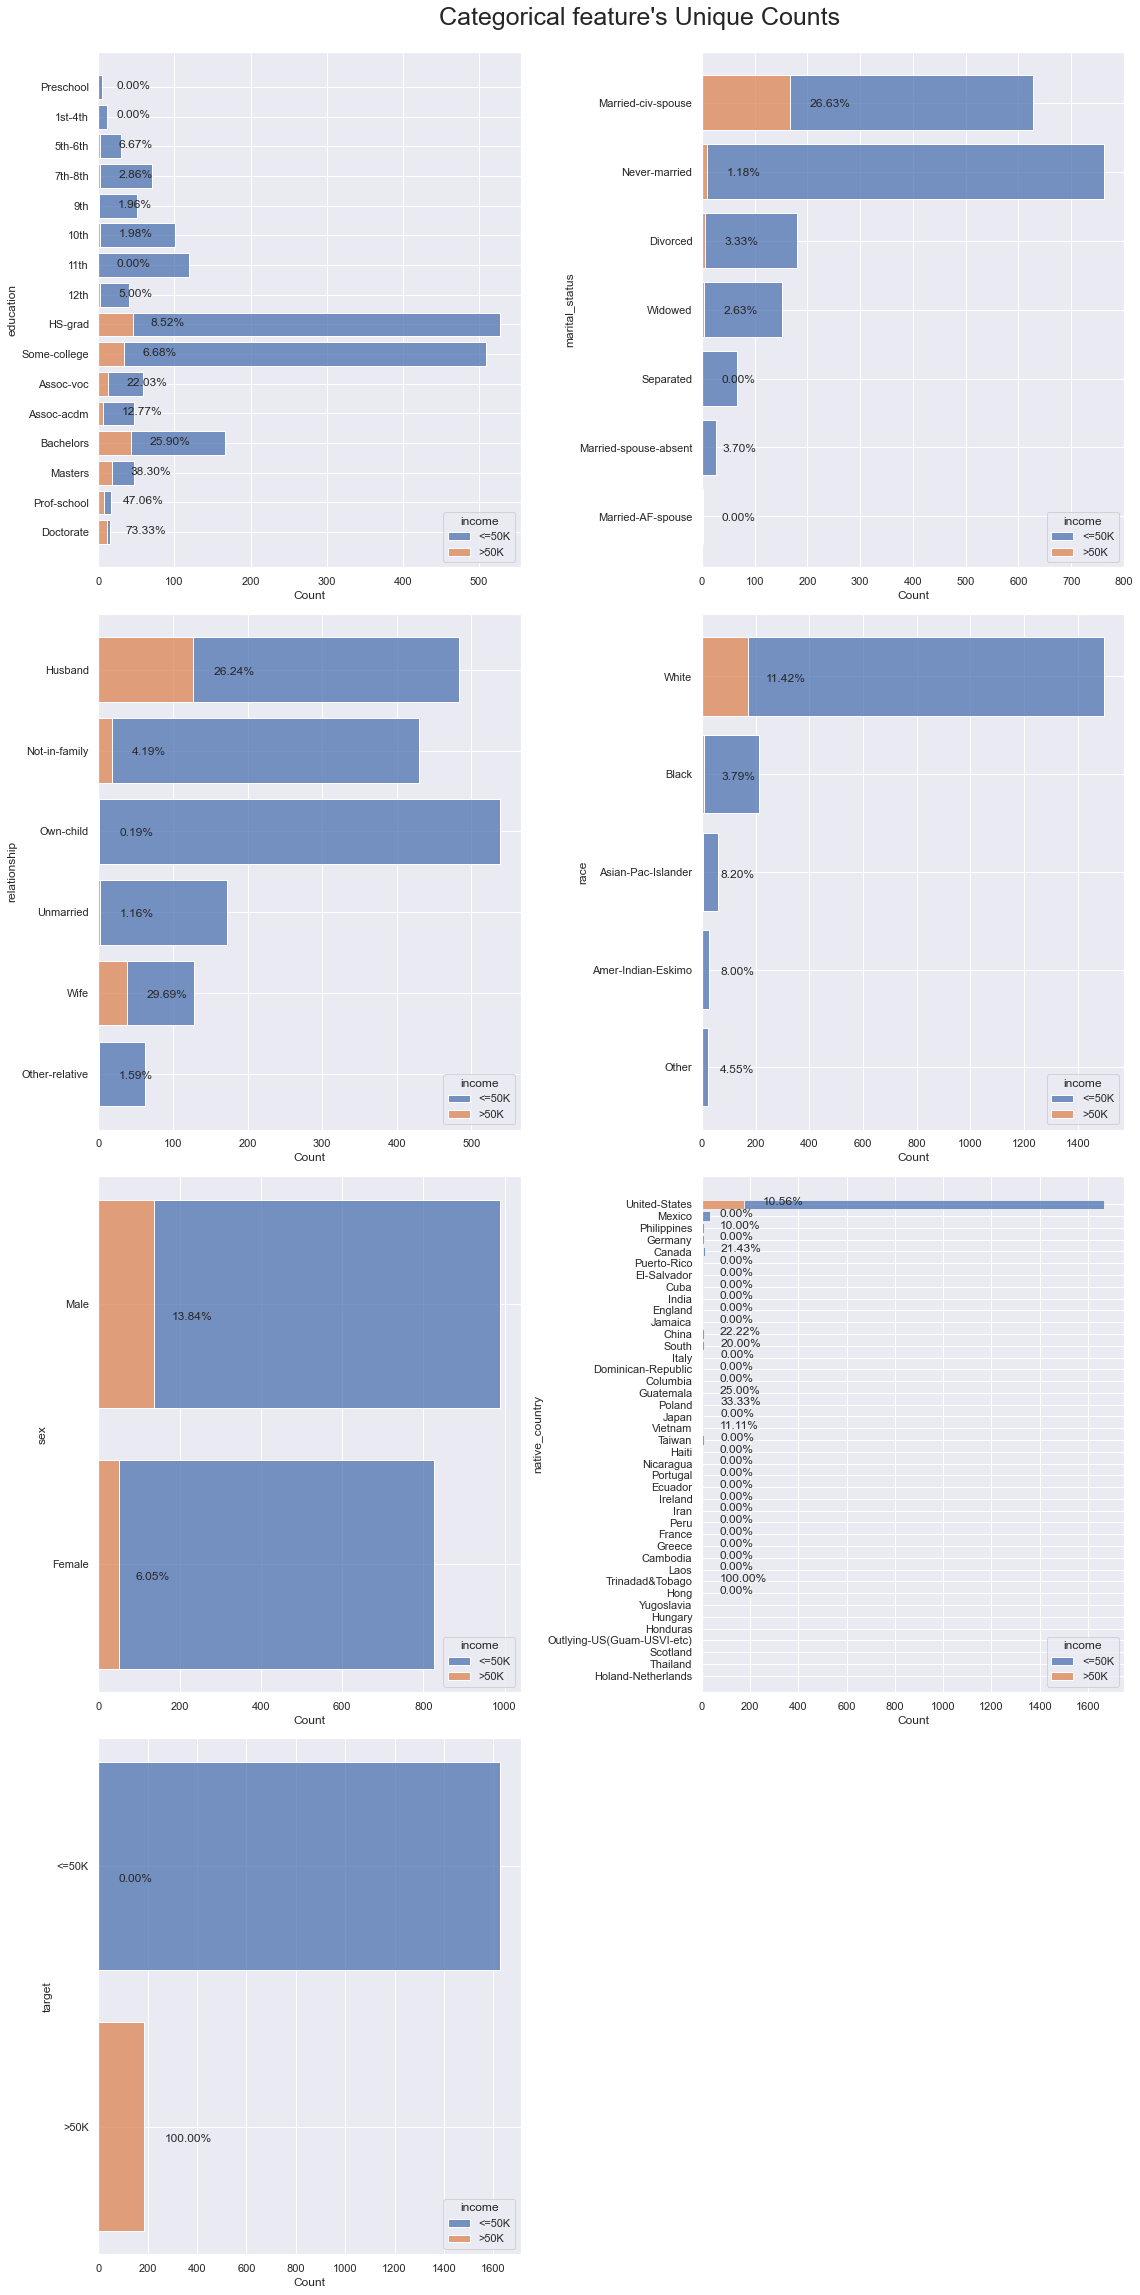

In [19]:
show_unique_counts(no_job.drop(['workclass', 'occupation'], axis=1), 'target')

`-` 확실히 직업이 결측치인 경우 소득이 적다

`-` 결측치가 무엇을 뜻하는지는 모르겠으나 소득이 50K보다 많은지 적은지를 판단할 때 도움이 될 것 같으니 버리지 말자

`-` 직업의 결측치는 Other로 처리하겠다

`-` 일의 유형 변수는 드랍할 것인데 일의 유형을 세부적으로 나눈게 직업이기 때문이다(둘이 겹치고 일의 유형으로 소득을 구분하기엔 부족하다 -> drop)

`-` 내친김에 국가가 결측치인 경우도 확인하자

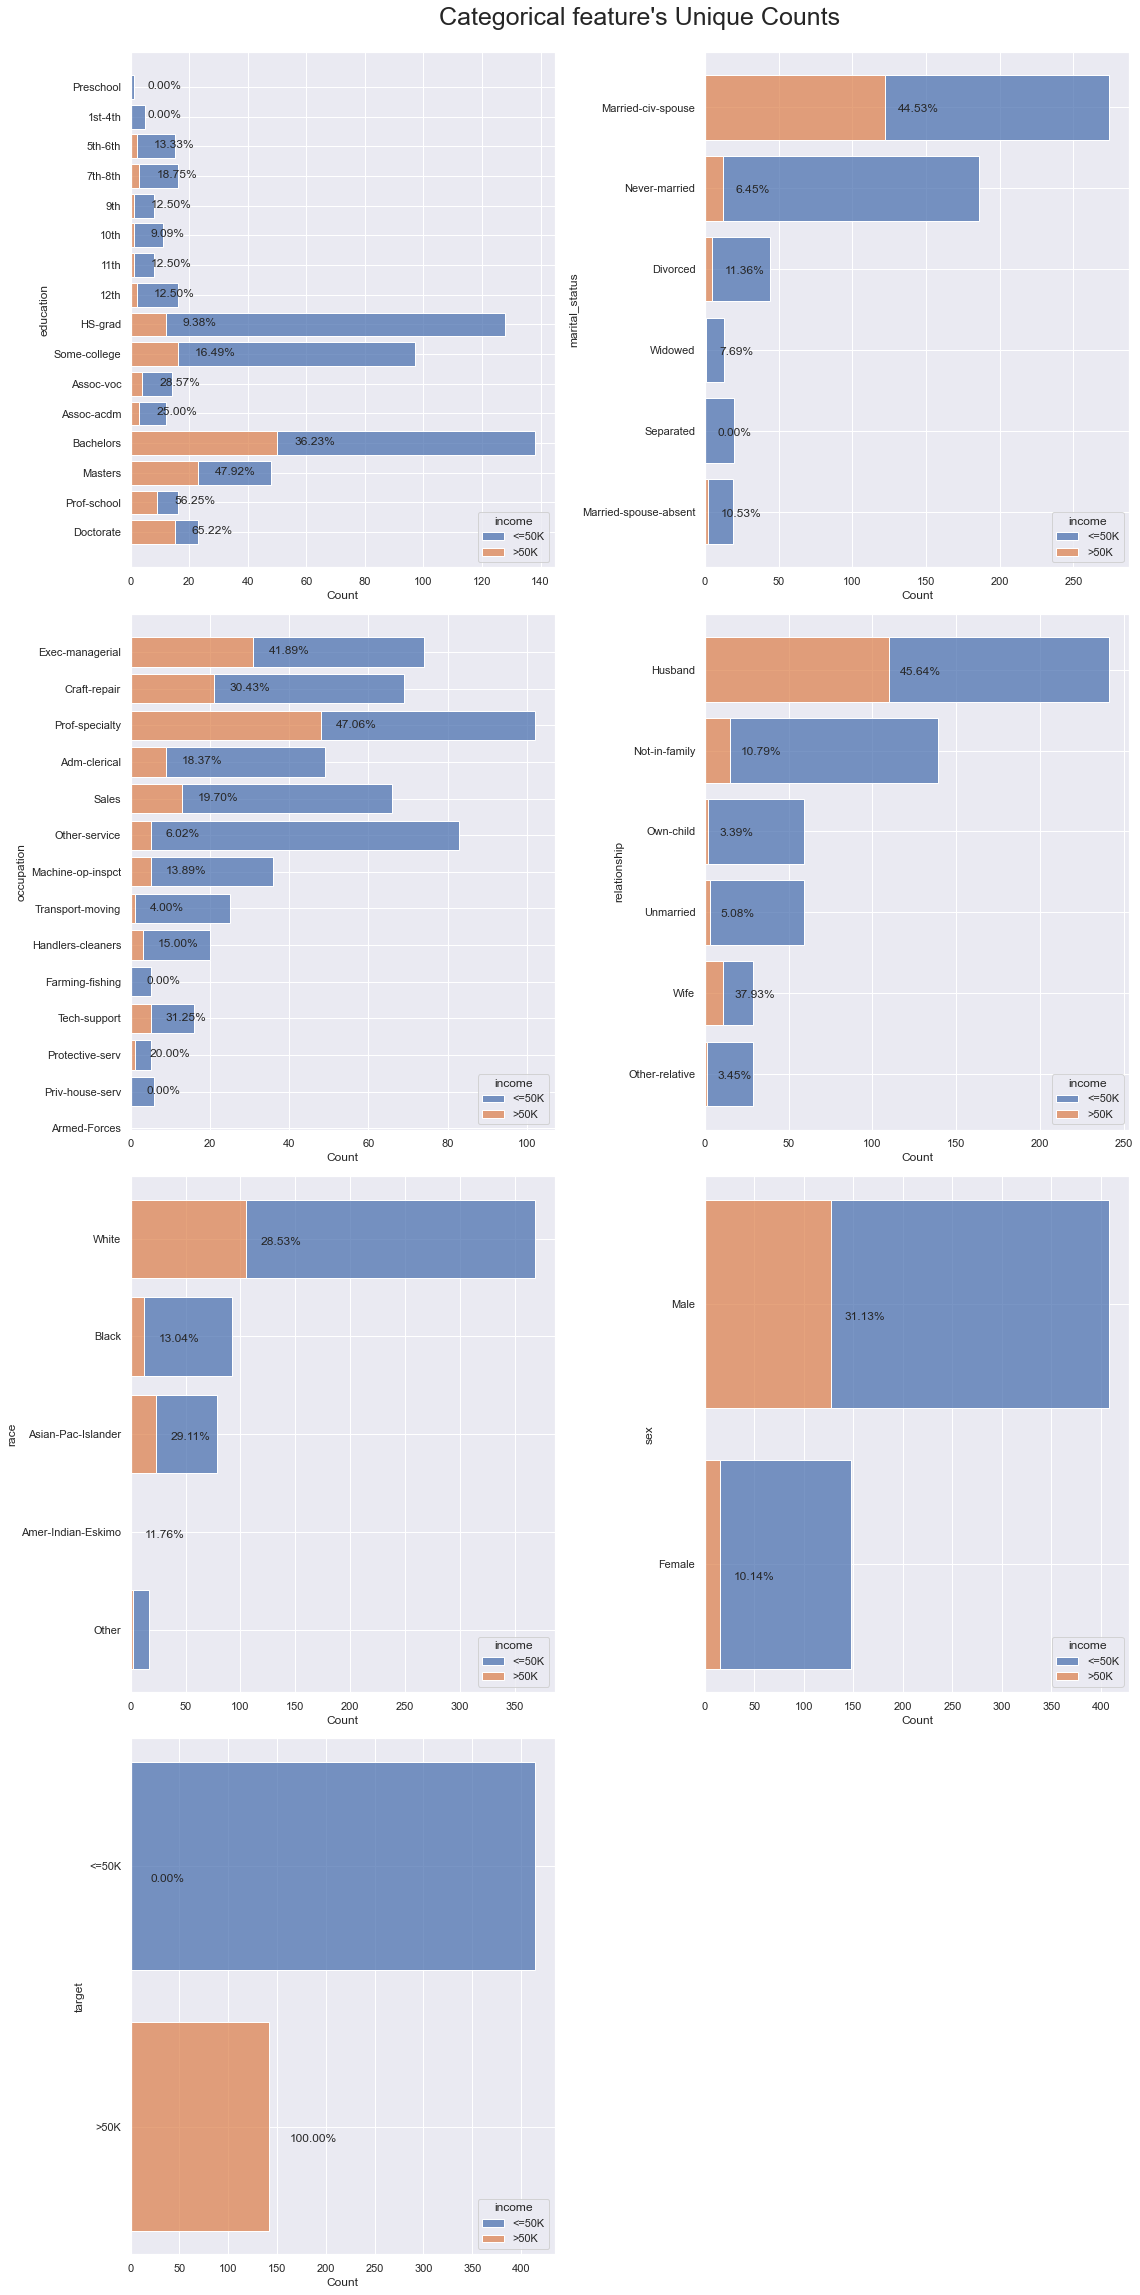

In [20]:
show_unique_counts(df[df['native_country'].isnull()].drop(['workclass', 'native_country'], axis=1), 'target')

`-` 국가의 결측치인 경우 소득의 분포는 미국보다 조금 더 고소득이다

`-` 눈에 띄는 점은 학사가 꽤 많다는 것

`-` 그냥 drop하는 것이 안전할 것 같음

`-` 아니면 target의 평균이 0.3(30%) 정도니까 비슷한 부류에 넣든지

### 양적 변수 시각화

`-` 소득 범주에 따른 violin plot을 그려보자

In [21]:
def show_violinplot(df_: pd.DataFrame, target: str) -> None:
    """ target 범주에 따른 양적 변수의 분포를 바이올린 플랏을 사용해 시각화하는 함수"""
    df = df_.copy()
    df = df.dropna() ## 결측치 제거
    ## len(df.columns[(df.dtypes == float) | (df.dtypes == np.int64)])의 결과를 보고 적절한 shape을 수동으로 지정해야 한다
    ## 결과값이 7이므로 4 X 2 크기의 figure를 만들자
    row, column = 4, 2
    fig, axs = plt.subplots(row, column, figsize=(12, 16))
    features = df.columns[(df.dtypes == float) | (df.dtypes == np.int64)]
    
    for i, feature in enumerate(features):
        ax = axs[i // column][i % column]
        gg = sns.violinplot(data=df, y=feature, x=target, ax=ax)

    ## 남는 서브 플랏은 삭제하자
    for ax in axs: ## axs의 row
        for k in [0, 1]: ## axs의 column
            if not ax[k].has_data(): ## ax[k]에 오브젝트가 없다면
                fig.delaxes(ax[k]) ## 남는 서브 플랏이니 삭제한다
                
    fig.suptitle("Violin Plot\n", x=0.53, fontsize=25) ## default: x=0.5, y=0.98
    fig.tight_layout()

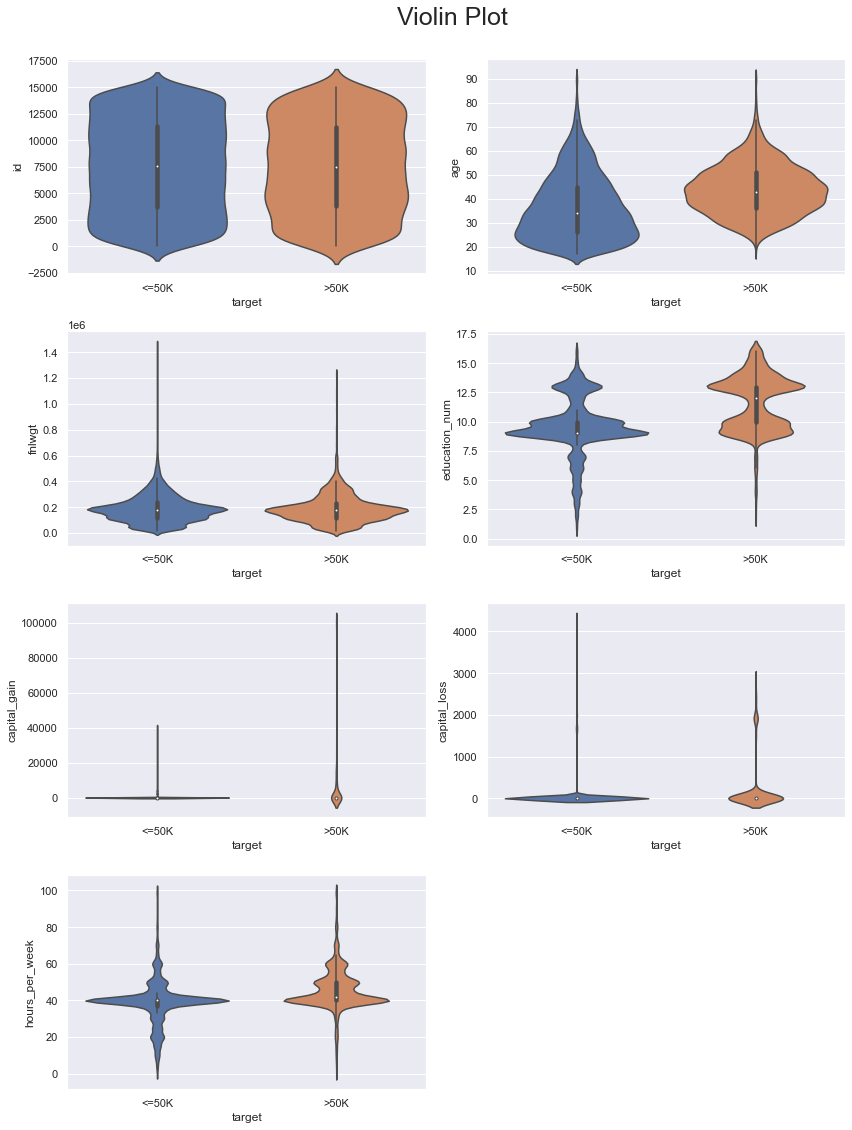

In [22]:
show_violinplot(df, 'target')

`-` 수입이 50K 이상인 사람이 평균적으로 나이가 더 많다

`-` `fnlwgt`은 수입과 관계가 없어보인다

`-` `capital_gain`과 `capital_loss`는 대부분 $0$에 값이 쏠려있다

`-` 그래서 둘다 꼬리가 긴 분포인데 자본 이익은 수입이 50K 이상인 사람들 분포의 꼬리가 더 길고

`-` 자본 손실은 수입이 50K 이하인 사람들 분포의 꼬리가 더 길다

`-` 수입이 50K 이상인 집단들의 자본 손실 분포를 보면 $2000$ 부근에 데이터가 좀 있는 것으로 보인다(why?)

`-` `hours_per_week`의 분포는 두 집단이 비슷한데 수입이 50K 이상인 집단이 조금 더 일을 많이 하는 경향이 있다

<AxesSubplot:>

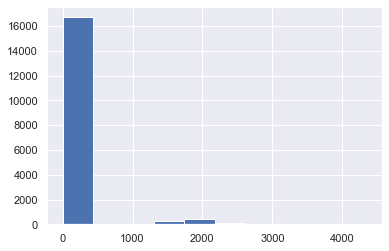

In [114]:
df['capital_loss'].hist()

`-` 신기한 분포이다...

In [115]:
df['captital_loss_approx2000'] = 'No' ## 이런거 변수명 어떻게 지음...

In [116]:
df.loc[(df['capital_loss'] >= 1500) & (df['target'] == '>50K') & (df['capital_loss'] < 2300), 'captital_loss_approx2000'] = 'Yes'

`-` 확인해봤는데 잘 모르겠다

`-` 원래의 분포와 비슷하게 생겼다

In [119]:
df.drop('captital_loss_approx2000', axis=1, inplace=True)

- 직업이 결측치인 경우 hours_per_week를 확인하자

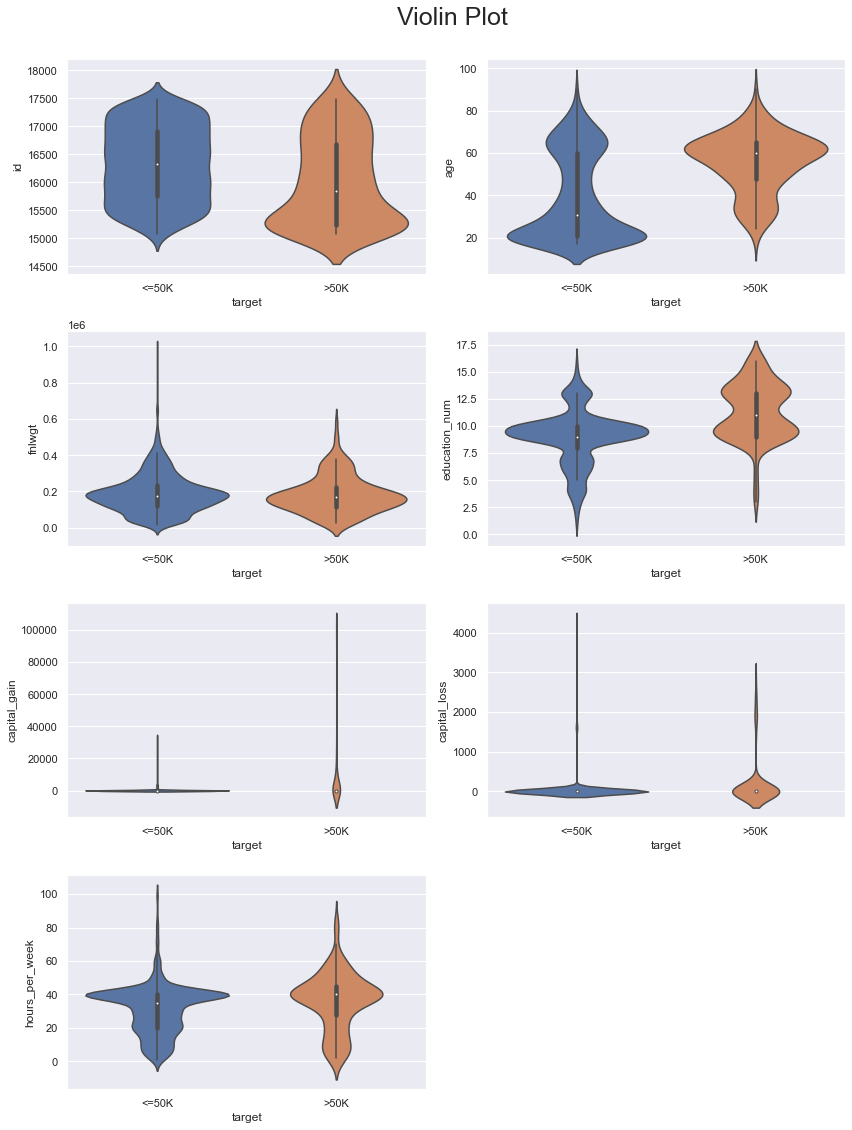

In [434]:
show_violinplot(no_job.drop(['workclass', 'occupation'], axis=1), 'target')

`-` 나이의 분포가 확연히 다르다

### CPS 가중치

`-` CPS 가중치가 정확히 뭔지 모르겠다

`-` 일단 값이 겁나 크다

`-` 성별, 인종, 직업 등등 취합해서 가중치를 매겼을텐데...

`-` 위에 바이올린 플랏을 보면 값이 클수록 희귀하니 좋은것 같다

`-` 이를 확인해보자

In [438]:
def show_boxplot(df_: pd.DataFrame, y: str, hue_feature: str = None) -> None:
    """ df의 변수 중에서 x를 범주형 변수로 하여 입력된 매개변수 따라 박스플랏 그리는 함수"""
    df = df_.copy()
    df = df.dropna() ## 결측치 제거
    ## len(df.columns[(df.dtypes == 'object') | (df.dtypes == 'category')])의 결과를 보고 적절한 shape을 수동으로 지정해야 한다
    ## 결과값이 9이므로 5 X 2 크기의 figure를 만들자
    row, column = 5, 2
    fig, axs = plt.subplots(row, column, figsize=(18, 28))
    features = df.columns[(df.dtypes == 'object') | (df.dtypes == 'category')]
    
    for i, feature in enumerate(features):
        ax = axs[i // column][i % column]
        order = df_[feature].sort_values().unique() ## dropna() 때문에 사라진 범주가 있어서 삭제 전의 df_를 기준으로 order를 만듦
        
        if hue_feature is not None:
            boxplot = sns.boxplot(data=df, x=feature, y=y, hue=hue_feature, ax=ax)
        else:
            boxplot = sns.boxplot(data=df, x=feature, y=y, ax=ax)
        boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation=90)
    
    ## 남는 서브 플랏은 삭제하자
    for ax in axs: ## axs의 row
        for k in [0, 1]: ## axs의 column
            if not ax[k].has_data(): ## ax[k]에 오브젝트가 없다면
                fig.delaxes(ax[k]) ## 남는 서브 플랏이니 삭제한다
                
    fig.suptitle("Box Plot\n", x=0.5, fontsize=25) ## default: x=0.5, y=0.98
    fig.tight_layout()

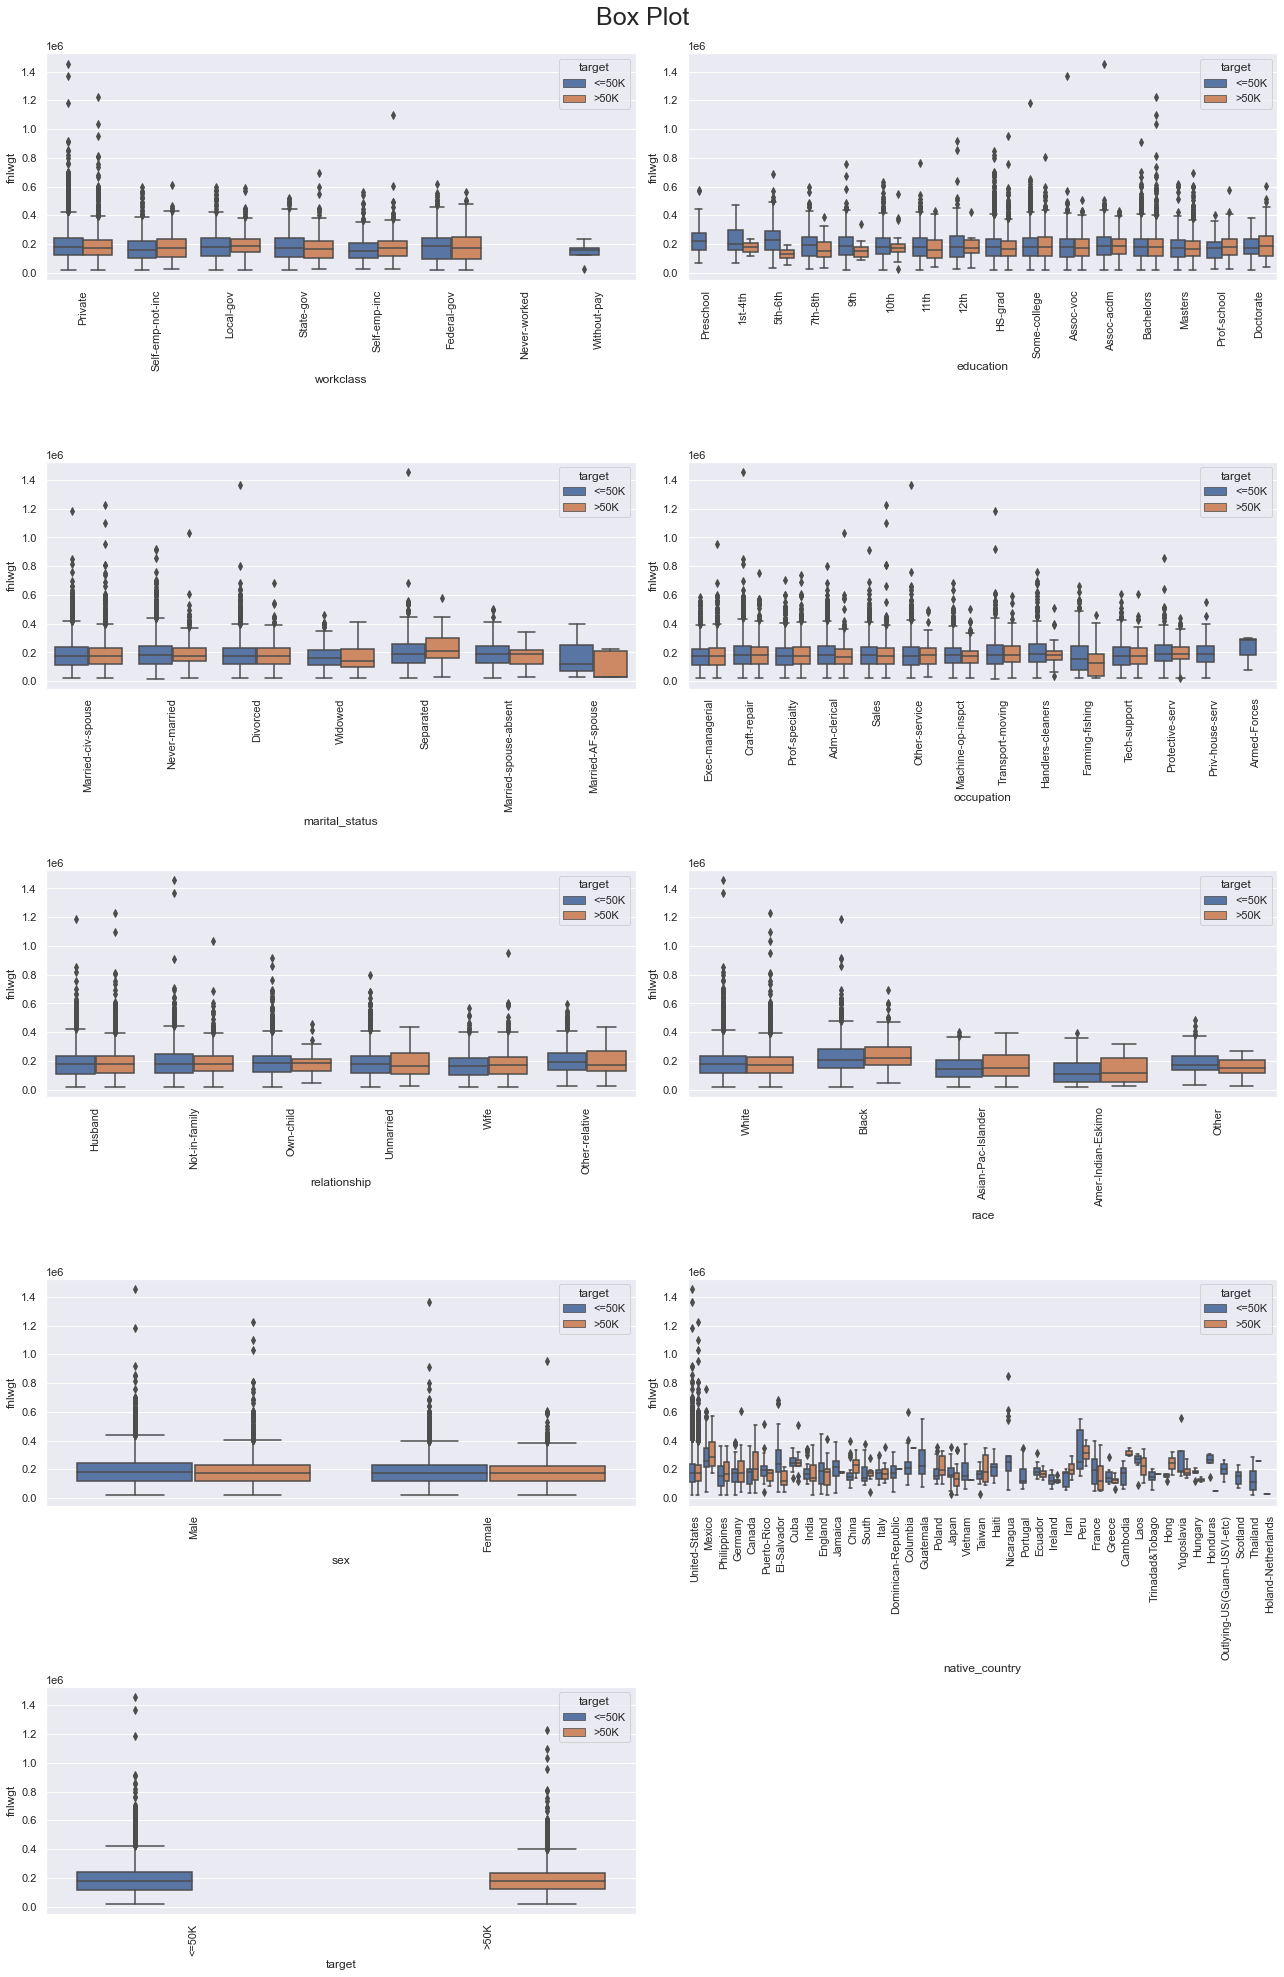

In [439]:
show_boxplot(df, 'fnlwgt', 'target')

`-` 응?

`-` 소득이 50K보다 작은 그룹이 그렇지 않은 그룹보다 분산이 더 크다

`-` 고소득 그룹은 데이터가 적어 산포가 클 것 같았는데 그렇지 않음

`-` 교육수준 번호가 작은 구간에서는 소득에 의해 나눠진 두 그룹의 차이가 눈에 띄는데 교육수준 번호가 커질수록 차이가 미미해진다

`-` 인종을 제외하면 별반 차이가 없다

`-` 소득에 따라 나누어 상자그림을 그리지 않고 합쳐서 그려보겠다

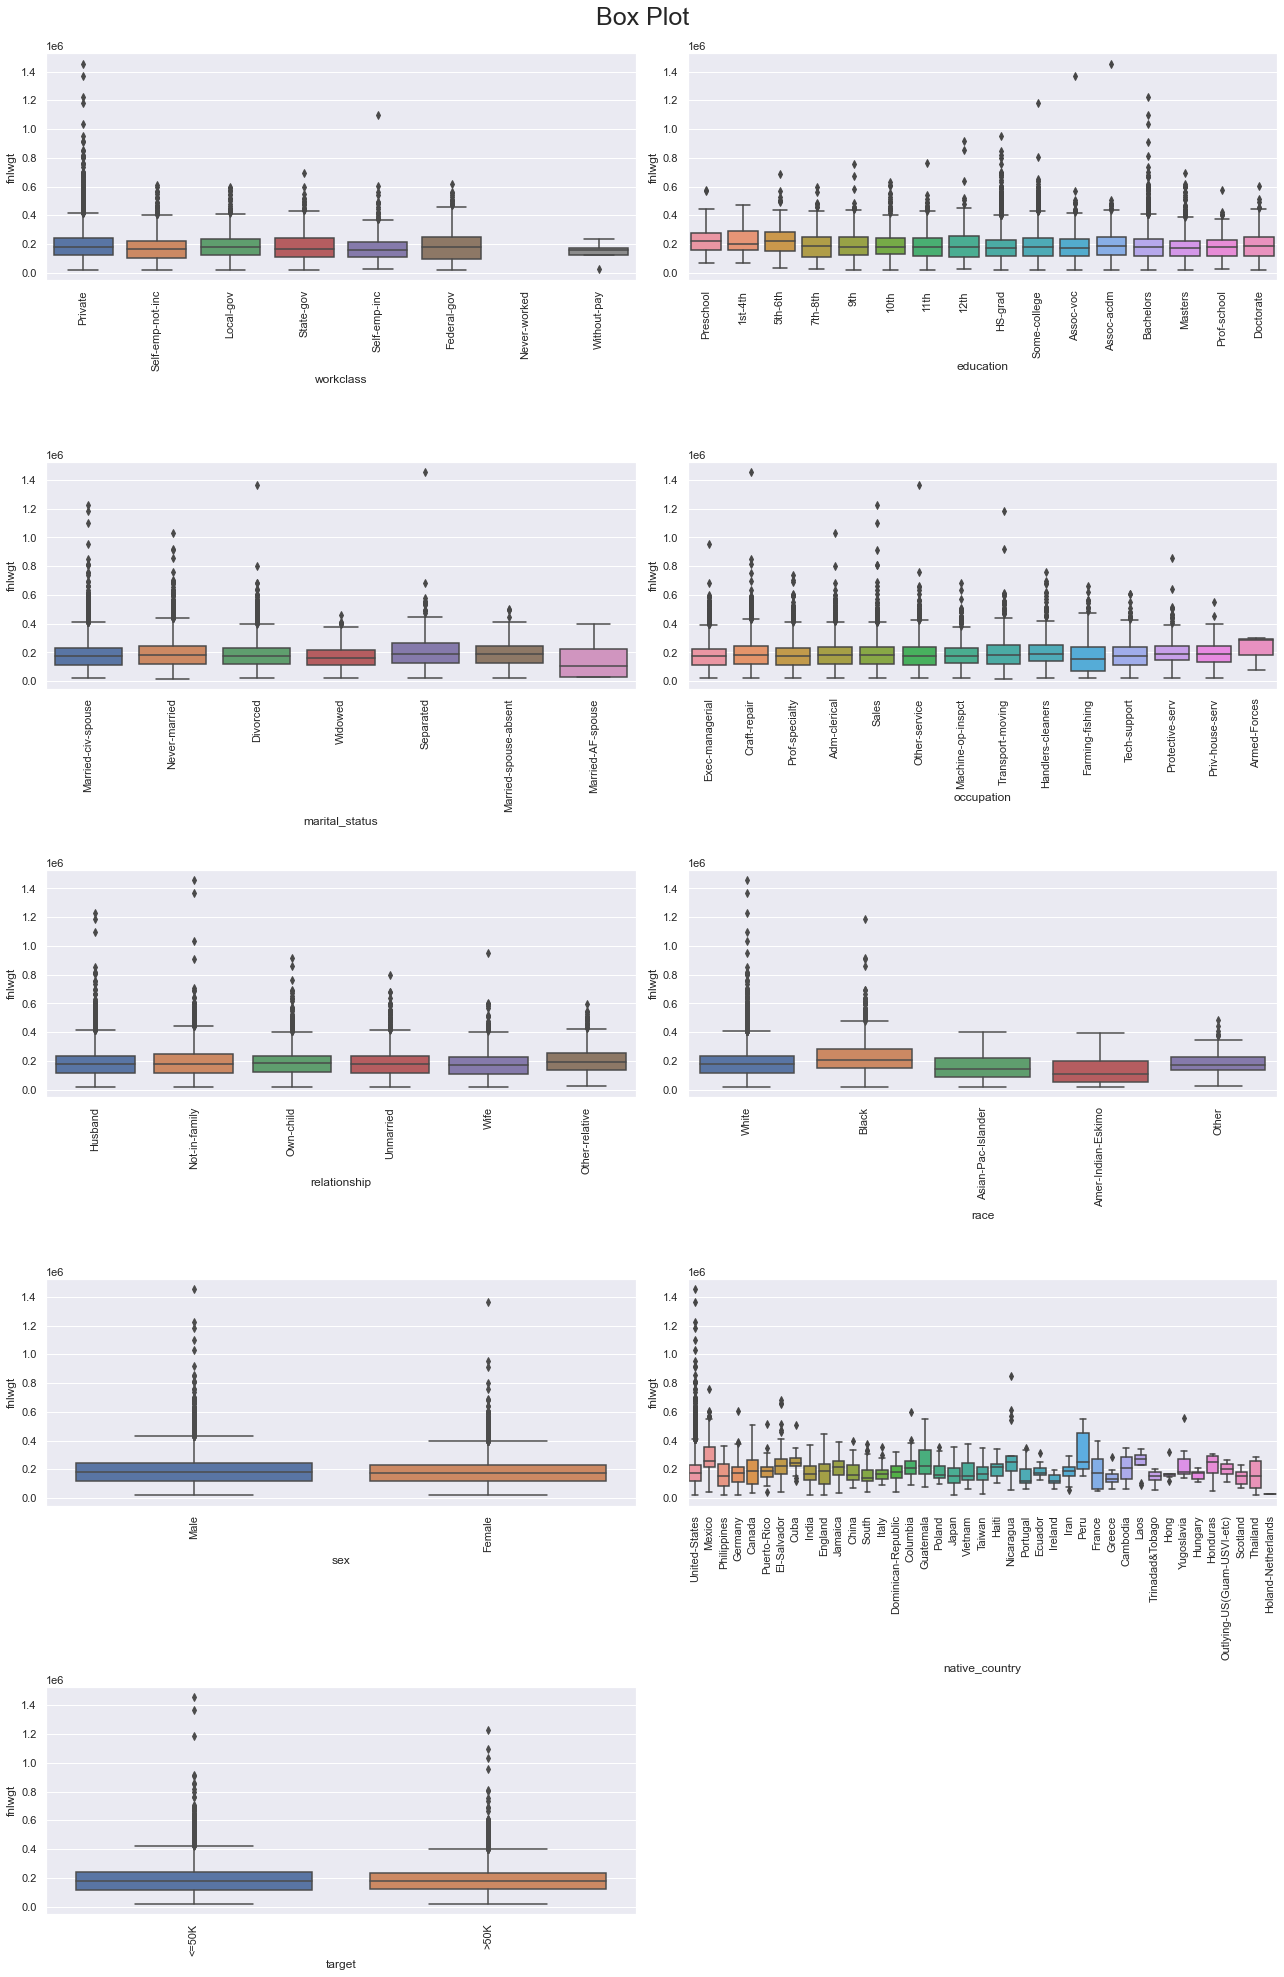

In [440]:
show_boxplot(df, 'fnlwgt')

`-` 마찬가지다

`-` 위의 상자그림을 보면 알 수 있는 것은 어떤 범주를 기준으로 상자그림을 그렸든 간에 중앙값은 $0.2(1e6)$ 부근이다

`-` 근데 인구 가중치는 여러 요소를 고려하여 만들어진 것이기에 하나의 변수가 끼치는 영향이 작을 것이다

`-` 그래서 차이가 거의 나지않는 것 같다

`-` 만약 빈도수로 가중치를 매긴다면 남자와 여자는 아마 가중치가 같을 것이다(대략 $1:1$ 이니까)

`-` 그렇다면 인종(race)을 제외하면 각각의 변수가 가지는 범주가 균등하게 나눠져 있다고 해석할 수 있을 것 같다(각 범주에 대해 골고루 분포한다)

`-` 근데 인종을 제외한 변수도 범주마다 빈도수가 확연히 다르다

`-` 다른 방식으로 가중치를 매기는 것 같다(어떤 방식인지 모름)

### 산점도 행렬

`-` 양적변수의 산점도 행렬을 그려보겠다

In [143]:
numeric_features = df.columns[(df.dtypes == np.int32) | (df.dtypes == np.int64)][1:-1].tolist() ## id와 target은 제거

In [144]:
numeric_features

['age',
 'fnlwgt',
 'education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week']

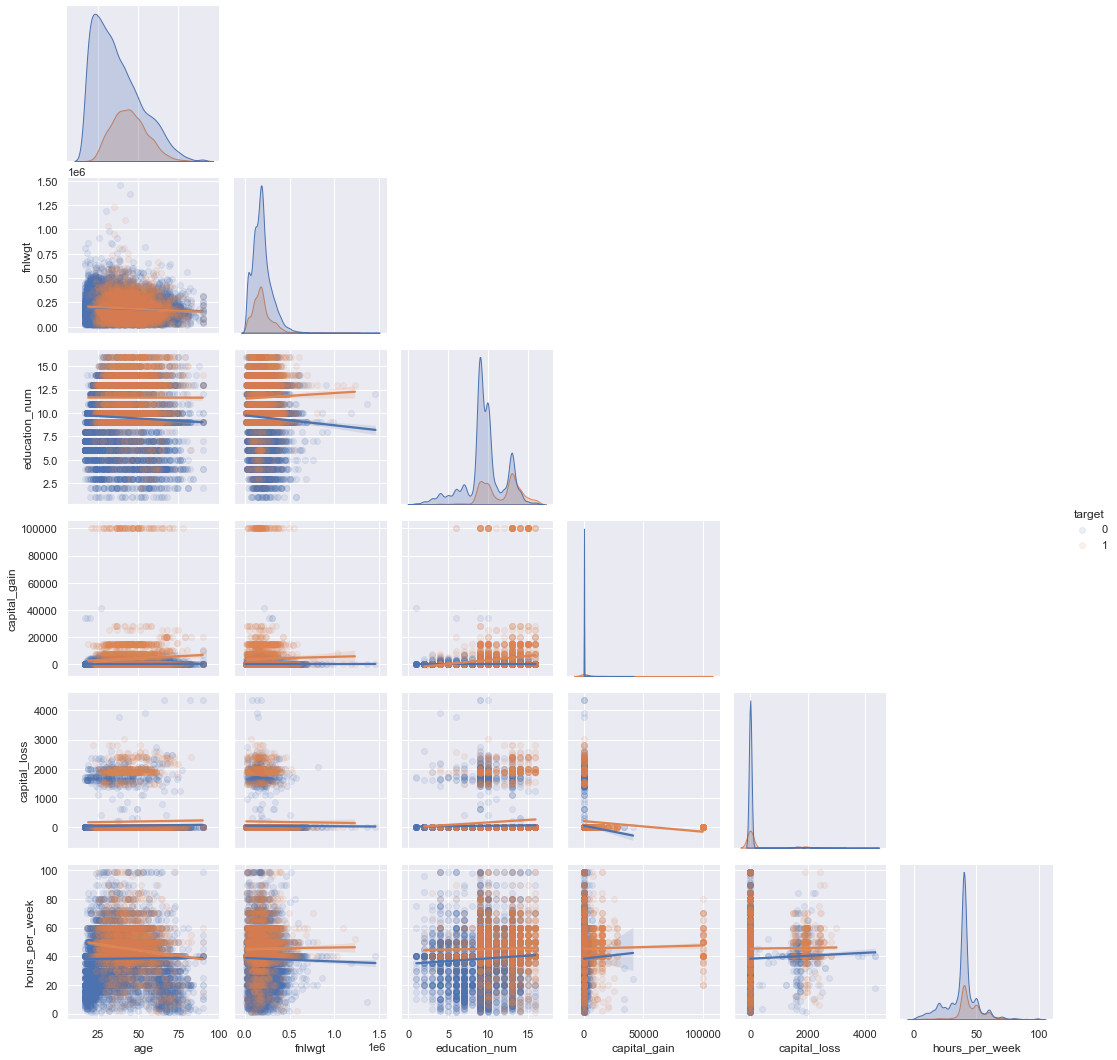

In [147]:
sns.pairplot(data=df, hue='target', kind='reg', vars=numeric_features, corner=True,  plot_kws={'scatter_kws': {'alpha': 0.1}})

`-` `capital_gain`과 `capital_loss`중 적어도 하나는 $0$이다

## 모델링

### 인코딩

`-` 카테고리 피쳐에 대해서 target의 비율이 비슷한 범주는 하나로 통합시키자

`-` 예컨대 직업같은 경우 직업의 이름 때문에 소득 차이가 발생하는게 아니라

`-` 그 직업이 하는 일이 돈을 많이 벌 수 있냐 아니냐에 따라서 차이가 생긴다

`-` 이를 직업(돈을 많이 벌 수 있는 가치가 있냐 없냐)의 특성으로 보고 같은 특성을 가지는 직업끼리 합치겠다

`-` 또한 occupation을 유형에 따라 나눈게 workclass인데 occupation이 더 세부적이고 target이 극단적으로 나뉘는 범주도 더 많으므로 workclass는 쓰지 않겠다

`-` 그리고 education은 education_num이 있으니까 사용하지 않겠다(education을 라벨인코딩 한 것이 education_num이다)

`-` 혼인 여부와 가족 관계 피쳐는 알맞게 하나로 합쳐서 사용하겠다(어떤식으로 합치는지는 코드 참고)

`-` fnlwgt은 플랏을 보니 target과 관련이 없어보여 드랍(고민 중)한다

In [403]:
df['target'] = df['target'].map({'<=50K':0, '>50K':1}).astype(int) ## 모델링을 위해 다시 숫자로 인코딩해주자

In [404]:
# df = df.dropna()

In [409]:
category2str(df)

In [410]:
df.loc[df['occupation'].isnull(), 'occupation'] = 'Other'
df.loc[df['native_country'].isnull(), 'native_country'] = 'Other'

In [407]:
def drop_features(df_: pd.DataFrame) -> pd.DataFrame:
    df = df_.copy()
    try:
        df.drop(['id',
                 #'workclass',
                 'education_num',
                 #'native_country',
                 'fnlwgt',
                ], axis=1, inplace=True)
    except:
        print('이미 drop된 feature가 있습니다')
    return df

In [408]:
class FeatureLevel:
    
    def __init__(self) -> None:
        self.mapping_rule = None
        
    def _get_level(self, rate: float) -> 'str':
        """target의 비율에 따라 적당히 구간을 나누고 속한 구간에 따라 레벨을 부여하는 함수"""
        if rate <= 0.02:
            return 'level0'
        elif rate <= 0.07:
            return 'level1'
        elif rate <= 0.12:
            return 'level2'
        elif rate <= 0.17:
            return 'level3'
        elif rate <= 0.25:
            return 'level4'
        elif rate <= 0.32:
            return 'level5'
        elif rate <= 0.39:
            return 'level6'
        elif rate <= 0.49:
            return 'level7'
        else:
            return 'level8'
        
    def _get_level_dict(self, df_: pd.DataFrame) -> None:
        """범주형 변수의 범주마다 그에 맞는 level을 저장하는 딕셔너리를 만드는 함수"""
        df = df_.copy()
        mapping_rule = {}

        features = df.columns[(df.dtypes == 'category') | (df.dtypes == 'object')]
        for feature in features:
            categories = df[feature].value_counts().index.tolist()
            for category in categories: 
                target_rate = df[df[feature] == category].loc[:, 'target'].to_numpy().mean()
                label = self._get_level(target_rate)
                mapping_rule[category] = label
                
        self.mapping_rule = mapping_rule
    
    def fit(self, X: pd.DataFrame) -> None:
        """X(train dataframe)로부터 맵핑규칙을 만드는 함수"""
        self._get_level_dict(X)
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """범주형 변수의 범주마다 그에 맞는 level을 맵핑한 df를 반환하는 함수"""
        df = X.copy()
        features = df.columns[(df.dtypes == 'category') | (df.dtypes == 'object')]
        for feature in features:
            df[feature] = df[feature].apply(lambda x: self.mapping_rule[x] if x in self.mapping_rule else 'no-level')
        return df

In [388]:
def label_encoding(df_):
    """level의 마지막 문자로 라벨을 지정하는 함수"""
    df = df_.copy()
    for feature in df.columns[(df.dtypes == 'object') | (df.dtypes == 'category')]:
        df[feature] = df[feature].apply(lambda x: int(x[5:]) if x != 'no-level' else 0)
    return df

`-` 인코딩을 하자

`-` Tree 모델은 라벨인코딩도 괜찮음

In [413]:
df2 = drop_features(df)
test2 = drop_features(test)

In [414]:
Level = FeatureLevel()

In [415]:
Level.fit(df2)

In [416]:
df2 = Level.transform(df2)
test2 = Level.transform(test2)

In [417]:
df2 = label_encoding(df2)
test2 = label_encoding(test2)

### 모델 하이퍼파라미터 튜닝 및 학습

In [612]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss

In [607]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [79]:
## accuracy 계산
def ACCURACY(true, pred):
    return sum(true == pred) / len(true)

In [418]:
k = 10
skfold = StratifiedKFold(k, shuffle=True, random_state=SEED)

In [419]:
target = df2['target']

In [420]:
df2.drop(['target'], axis=1, inplace=True) 

`-` HP 튜닝

In [658]:
def lgbm_objective(trial: Trial) -> float:
    score_list = []
    params_lgbm = {
        'random_state': SEED,
        'verbosity': -1,
        'learning_rate': 0.05,
        'n_estimators': 5000,
        'objective': 'binary',
        'metric': 'binary_logloss',
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 3e-5),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 9e-2),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 300),
        'max_bin': trial.suggest_int('max_bin', 200, 500),
    }

    for i, (train_idx, valid_idx) in enumerate(skfold.split(df2, target)):            
        X_train, y_train = df2.iloc[train_idx], target[train_idx]
        X_valid, y_valid = df2.iloc[valid_idx], target[valid_idx]

        LGBM = LGBMClassifier(**params_lgbm)    
        LGBM.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=50,
            verbose=False
        )

        lgbm_pred = LGBM.predict_proba(X_valid)
        logloss_score = log_loss(y_valid, lgbm_pred)
        score_list.append(logloss_score)
    
    return np.mean(score_list)

In [659]:
sampler = TPESampler(seed=SEED)
study = optuna.create_study(
    study_name='lgbm_parameter_opt',
    direction='minimize',
    sampler=sampler,
)

study.optimize(lgbm_objective, n_trials=50)
print('Best Score:', study.best_value)
print('Best trial:', study.best_trial.params)

[I 2022-04-28 17:30:55,195] A new study created in memory with name: lgbm_parameter_opt
[I 2022-04-28 17:31:01,339] Trial 0 finished with value: 0.2916222339178439 and parameters: {'reg_alpha': 6.26173151539169e-06, 'reg_lambda': 0.043351300741892314, 'max_depth': 10, 'num_leaves': 221, 'colsample_bytree': 0.502696932167004, 'subsample': 0.5372047724225902, 'subsample_freq': 3, 'min_child_samples': 209, 'max_bin': 266}. Best is trial 0 with value: 0.2916222339178439.
[I 2022-04-28 17:31:05,328] Trial 1 finished with value: 0.29475542726306264 and parameters: {'reg_alpha': 2.4360408106955213e-05, 'reg_lambda': 0.0009474285831810162, 'max_depth': 13, 'num_leaves': 209, 'colsample_bytree': 0.8470601776353014, 'subsample': 0.4323779486823934, 'subsample_freq': 1, 'min_child_samples': 233, 'max_bin': 488}. Best is trial 0 with value: 0.2916222339178439.
[I 2022-04-28 17:31:12,925] Trial 2 finished with value: 0.28833285851644425 and parameters: {'reg_alpha': 2.106111714398839e-05, 'reg_lamb

Best Score: 0.2742807524466267
Best trial: {'reg_alpha': 2.3273730793676095e-05, 'reg_lambda': 0.06919950576887485, 'max_depth': 7, 'num_leaves': 254, 'colsample_bytree': 0.5270538056201184, 'subsample': 0.9980254726717414, 'subsample_freq': 7, 'min_child_samples': 58, 'max_bin': 233}


`-` 모델 학습

In [692]:
best_params = study.best_params
best_params['learning_rate'] = 0.05
best_params['n_estimators'] = 5000
best_params['random_state'] = SEED

In [691]:
CB = CatBoostClassifier(n_estimators=1500,
                        learning_rate=0.03,
                        depth=5, 
                        random_state=SEED,
                        use_best_model=True,
                        verbose=0)

In [664]:
LGBM = LGBMClassifier(**best_params)

In [666]:
XGB = XGBClassifier(n_estimators=1500,
                    learning_rate=0.03,
                    max_depth=6,
                    random_state=SEED,
                    eval_metric='logloss')

In [667]:
def OOF_predict(model, X, y, test,  SKfold, threshold=0.5, use_category_feature=False):
    """
    Out-Of-Fold 방식을 통해 test를 예측
    """ 
    model_valid_score = []
    model_predict = np.zeros(shape=(test.shape[0], len(y.unique())))

    for i, (train_idx, valid_idx) in tqdm(enumerate(SKfold.split(X, y))):
        print(f'({i + 1} / {SKfold.n_splits}) Fold Training......')
        X_train, y_train = X.iloc[train_idx], y[train_idx]
        X_valid, y_valid = X.iloc[valid_idx], y[valid_idx]
        
        if use_category_feature:
            if model.__class__.__name__.find('CatBoost') != -1:
                ## Catboost를 사용할 때 카테고리 피쳐 지정
                pool_train = Pool(X_train, y_train, cat_features=X.columns[X.dtypes == 'category'].tolist())
                pool_valid = Pool(X_valid, cat_features=X.columns[X.dtypes == 'category'].tolist())
                pool_test = Pool(test, cat_features=test.columns[test.dtypes == 'category'].tolist())

                ## model 적합
                model.fit(pool_train)

                ## valid, test 예측
                y_predict = model.predict_proba(pool_valid)
                test_predict = model.predict_proba(pool_test)  ## 각 클래스별 확률(test)을 구함
            else:
                ## model 적합
                model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], early_stopping_rounds=50, eval_metric='logloss', verbose=200)

                ## valid, test 예측
                y_predict = model.predict_proba(X_valid)
                test_predict = model.predict_proba(test)  ## 각 클래스별 확률(test)을 구함
        else:
            if model.__class__.__name__.find('CatBoost') != -1:
                model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)],  early_stopping_rounds=50, verbose=200)
                y_predict = model.predict_proba(X_valid)
                test_predict = model.predict_proba(test)  ## 각 클래스별 확률(test)을 구함
            else:
                ## model 적합
                model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], early_stopping_rounds=50, eval_metric='logloss', verbose=200)

                ## valid, test 예측
                y_predict = model.predict_proba(X_valid)
                test_predict = model.predict_proba(test)  ## 각 클래스별 확률(test)을 구함

        ## valid 예측
        y_predict = (y_predict[:, 1] > threshold).astype(int) ## 1번째 컬럼(1일 확률)의 값이 threshold보다 크면 1 아니면 0으로 계산
        model_valid_score.append(ACCURACY(y_predict, y_valid)) ## valid 정확도
        
        ## test 합산
        model_predict += test_predict / SKfold.n_splits ## test 예측값(k Fold)
    
    ## prob를 바탕으로 argmax 계산
    # model_predict = model_predict.argmax(-1)  ## 주석처리하면 확률을 반환             
    return model_valid_score, model_predict

In [678]:
LGBM_valid_acc, LGBM_test_pred = OOF_predict(LGBM, df2, target, test2, skfold, threshold=0.485)

0it [00:00, ?it/s]

(1 / 10) Fold Training......
[200]	training's binary_logloss: 0.253048	valid_1's binary_logloss: 0.26825
[400]	training's binary_logloss: 0.237058	valid_1's binary_logloss: 0.265097


1it [00:01,  1.24s/it]

(2 / 10) Fold Training......
[200]	training's binary_logloss: 0.252988	valid_1's binary_logloss: 0.271818


2it [00:02,  1.11s/it]

(3 / 10) Fold Training......
[200]	training's binary_logloss: 0.251888	valid_1's binary_logloss: 0.278566


3it [00:03,  1.01it/s]

(4 / 10) Fold Training......
[200]	training's binary_logloss: 0.252052	valid_1's binary_logloss: 0.274366


4it [00:03,  1.08it/s]

(5 / 10) Fold Training......
[200]	training's binary_logloss: 0.253395	valid_1's binary_logloss: 0.270277


5it [00:04,  1.11it/s]

(6 / 10) Fold Training......
[200]	training's binary_logloss: 0.252871	valid_1's binary_logloss: 0.270489


6it [00:05,  1.15it/s]

(7 / 10) Fold Training......
[200]	training's binary_logloss: 0.250256	valid_1's binary_logloss: 0.292497


7it [00:06,  1.21it/s]

(8 / 10) Fold Training......
[200]	training's binary_logloss: 0.252944	valid_1's binary_logloss: 0.274054


8it [00:07,  1.14it/s]

(9 / 10) Fold Training......
[200]	training's binary_logloss: 0.253611	valid_1's binary_logloss: 0.27751


9it [00:08,  1.18it/s]

(10 / 10) Fold Training......
[200]	training's binary_logloss: 0.251149	valid_1's binary_logloss: 0.283907


10it [00:08,  1.11it/s]


In [679]:
print(f'LGBM 모델의 평균과 표준편차: {np.mean(LGBM_valid_acc)}, {np.std(LGBM_valid_acc)}') 

LGBM 모델의 평균과 표준편차: 0.8723684210526315, 0.0056543622256572815


`-` 아래는 Optuna 안쓴 모델

In [688]:
LGBM = LGBMClassifier(n_estimators=1500,
                      learning_rate=0.03,
                      max_depth=6,
                      random_state=SEED,
                      eval_metric='logloss')

In [610]:
LGBM_valid_acc, LGBM_test_pred = OOF_predict(LGBM, df2, target, test2, skfold, threshold=0.51)

0it [00:00, ?it/s]

(1 / 10) Fold Training......
[200]	training's binary_logloss: 0.261225	valid_1's binary_logloss: 0.272294
[400]	training's binary_logloss: 0.242468	valid_1's binary_logloss: 0.263894
[600]	training's binary_logloss: 0.232335	valid_1's binary_logloss: 0.261184


1it [00:01,  1.46s/it]

(2 / 10) Fold Training......
[200]	training's binary_logloss: 0.260975	valid_1's binary_logloss: 0.278351
[400]	training's binary_logloss: 0.242644	valid_1's binary_logloss: 0.270432


2it [00:02,  1.10s/it]

(3 / 10) Fold Training......
[200]	training's binary_logloss: 0.260982	valid_1's binary_logloss: 0.283263
[400]	training's binary_logloss: 0.24208	valid_1's binary_logloss: 0.276142


3it [00:03,  1.11s/it]

(4 / 10) Fold Training......
[200]	training's binary_logloss: 0.259857	valid_1's binary_logloss: 0.279811
[400]	training's binary_logloss: 0.241922	valid_1's binary_logloss: 0.275603


4it [00:04,  1.08s/it]

(5 / 10) Fold Training......
[200]	training's binary_logloss: 0.262184	valid_1's binary_logloss: 0.276068
[400]	training's binary_logloss: 0.24369	valid_1's binary_logloss: 0.268765


5it [00:05,  1.04s/it]

(6 / 10) Fold Training......
[200]	training's binary_logloss: 0.260777	valid_1's binary_logloss: 0.277069
[400]	training's binary_logloss: 0.242103	valid_1's binary_logloss: 0.269936


6it [00:06,  1.00s/it]

(7 / 10) Fold Training......
[200]	training's binary_logloss: 0.259592	valid_1's binary_logloss: 0.298679
[400]	training's binary_logloss: 0.241801	valid_1's binary_logloss: 0.292934


7it [00:07,  1.09s/it]

(8 / 10) Fold Training......
[200]	training's binary_logloss: 0.261737	valid_1's binary_logloss: 0.278759
[400]	training's binary_logloss: 0.242765	valid_1's binary_logloss: 0.272118


8it [00:08,  1.13s/it]

(9 / 10) Fold Training......
[200]	training's binary_logloss: 0.261176	valid_1's binary_logloss: 0.284996
[400]	training's binary_logloss: 0.243529	valid_1's binary_logloss: 0.280782


9it [00:09,  1.08s/it]

(10 / 10) Fold Training......
[200]	training's binary_logloss: 0.259497	valid_1's binary_logloss: 0.285913
[400]	training's binary_logloss: 0.241641	valid_1's binary_logloss: 0.28225


10it [00:10,  1.08s/it]


In [432]:
LGBM_valid_acc, LGBM_test_pred = OOF_predict(LGBM, df2, target, test2, skfold, threshold=0.51)

0it [00:00, ?it/s]

(1 / 10) Fold Training......
[200]	training's binary_logloss: 0.261225	valid_1's binary_logloss: 0.272294
[400]	training's binary_logloss: 0.242468	valid_1's binary_logloss: 0.263894
[600]	training's binary_logloss: 0.232335	valid_1's binary_logloss: 0.261184


1it [00:01,  1.43s/it]

(2 / 10) Fold Training......
[200]	training's binary_logloss: 0.260975	valid_1's binary_logloss: 0.278351
[400]	training's binary_logloss: 0.242644	valid_1's binary_logloss: 0.270432


2it [00:02,  1.07s/it]

(3 / 10) Fold Training......
[200]	training's binary_logloss: 0.260982	valid_1's binary_logloss: 0.283263
[400]	training's binary_logloss: 0.24208	valid_1's binary_logloss: 0.276142


3it [00:03,  1.08s/it]

(4 / 10) Fold Training......
[200]	training's binary_logloss: 0.259857	valid_1's binary_logloss: 0.279811
[400]	training's binary_logloss: 0.241922	valid_1's binary_logloss: 0.275603


4it [00:04,  1.03s/it]

(5 / 10) Fold Training......
[200]	training's binary_logloss: 0.262184	valid_1's binary_logloss: 0.276068
[400]	training's binary_logloss: 0.24369	valid_1's binary_logloss: 0.268765


5it [00:05,  1.00s/it]

(6 / 10) Fold Training......
[200]	training's binary_logloss: 0.260777	valid_1's binary_logloss: 0.277069
[400]	training's binary_logloss: 0.242103	valid_1's binary_logloss: 0.269936


6it [00:06,  1.03it/s]

(7 / 10) Fold Training......
[200]	training's binary_logloss: 0.259592	valid_1's binary_logloss: 0.298679
[400]	training's binary_logloss: 0.241801	valid_1's binary_logloss: 0.292934


7it [00:07,  1.04it/s]

(8 / 10) Fold Training......
[200]	training's binary_logloss: 0.261737	valid_1's binary_logloss: 0.278759
[400]	training's binary_logloss: 0.242765	valid_1's binary_logloss: 0.272118


8it [00:08,  1.00it/s]

(9 / 10) Fold Training......
[200]	training's binary_logloss: 0.261176	valid_1's binary_logloss: 0.284996
[400]	training's binary_logloss: 0.243529	valid_1's binary_logloss: 0.280782


9it [00:09,  1.05it/s]

(10 / 10) Fold Training......
[200]	training's binary_logloss: 0.259497	valid_1's binary_logloss: 0.285913
[400]	training's binary_logloss: 0.241641	valid_1's binary_logloss: 0.28225


10it [00:10,  1.01s/it]


In [452]:
XGB_valid_acc, XGB_test_pred = OOF_predict(XGB, df2, target, test2, skfold, threshold=0.51)

0it [00:00, ?it/s]

(1 / 10) Fold Training......
[0]	validation_0-logloss:0.67543	validation_1-logloss:0.67507
[200]	validation_0-logloss:0.26155	validation_1-logloss:0.27444
[400]	validation_0-logloss:0.24543	validation_1-logloss:0.26611
[600]	validation_0-logloss:0.23604	validation_1-logloss:0.26456
[773]	validation_0-logloss:0.23083	validation_1-logloss:0.26440


1it [00:06,  6.11s/it]

(2 / 10) Fold Training......
[0]	validation_0-logloss:0.67543	validation_1-logloss:0.67569
[200]	validation_0-logloss:0.26206	validation_1-logloss:0.28112
[400]	validation_0-logloss:0.24509	validation_1-logloss:0.27140
[539]	validation_0-logloss:0.23867	validation_1-logloss:0.27013


2it [00:10,  4.82s/it]

(3 / 10) Fold Training......
[0]	validation_0-logloss:0.67539	validation_1-logloss:0.67558
[200]	validation_0-logloss:0.26133	validation_1-logloss:0.28637
[400]	validation_0-logloss:0.24488	validation_1-logloss:0.27946
[600]	validation_0-logloss:0.23556	validation_1-logloss:0.27736
[677]	validation_0-logloss:0.23304	validation_1-logloss:0.27759


3it [00:14,  4.87s/it]

(4 / 10) Fold Training......
[0]	validation_0-logloss:0.67537	validation_1-logloss:0.67545
[200]	validation_0-logloss:0.26136	validation_1-logloss:0.27830
[400]	validation_0-logloss:0.24380	validation_1-logloss:0.27417
[440]	validation_0-logloss:0.24146	validation_1-logloss:0.27418


4it [00:18,  4.28s/it]

(5 / 10) Fold Training......
[0]	validation_0-logloss:0.67547	validation_1-logloss:0.67561
[200]	validation_0-logloss:0.26211	validation_1-logloss:0.27716
[400]	validation_0-logloss:0.24470	validation_1-logloss:0.26997
[600]	validation_0-logloss:0.23569	validation_1-logloss:0.26862
[644]	validation_0-logloss:0.23356	validation_1-logloss:0.26895


5it [00:23,  4.42s/it]

(6 / 10) Fold Training......
[0]	validation_0-logloss:0.67536	validation_1-logloss:0.67545
[200]	validation_0-logloss:0.26133	validation_1-logloss:0.27804
[400]	validation_0-logloss:0.24468	validation_1-logloss:0.27099
[588]	validation_0-logloss:0.23669	validation_1-logloss:0.27082


6it [00:27,  4.43s/it]

(7 / 10) Fold Training......
[0]	validation_0-logloss:0.67530	validation_1-logloss:0.67592
[200]	validation_0-logloss:0.26034	validation_1-logloss:0.29930
[400]	validation_0-logloss:0.24319	validation_1-logloss:0.29364
[600]	validation_0-logloss:0.23439	validation_1-logloss:0.29256
[791]	validation_0-logloss:0.22896	validation_1-logloss:0.29205


7it [00:33,  4.83s/it]

(8 / 10) Fold Training......
[0]	validation_0-logloss:0.67534	validation_1-logloss:0.67562
[200]	validation_0-logloss:0.26164	validation_1-logloss:0.27974
[400]	validation_0-logloss:0.24497	validation_1-logloss:0.27274
[535]	validation_0-logloss:0.23765	validation_1-logloss:0.27180


8it [00:38,  4.92s/it]

(9 / 10) Fold Training......
[0]	validation_0-logloss:0.67541	validation_1-logloss:0.67532
[200]	validation_0-logloss:0.26154	validation_1-logloss:0.28479
[400]	validation_0-logloss:0.24458	validation_1-logloss:0.28069
[420]	validation_0-logloss:0.24357	validation_1-logloss:0.28069


9it [00:41,  4.46s/it]

(10 / 10) Fold Training......
[0]	validation_0-logloss:0.67535	validation_1-logloss:0.67589
[200]	validation_0-logloss:0.26051	validation_1-logloss:0.28612
[400]	validation_0-logloss:0.24281	validation_1-logloss:0.28077
[561]	validation_0-logloss:0.23539	validation_1-logloss:0.28024


10it [00:45,  4.59s/it]


In [465]:
CB_valid_acc, CB_test_pred = OOF_predict(CB, df2, target, test2, skfold, threshold=0.51)

0it [00:00, ?it/s]

(1 / 10) Fold Training......
0:	learn: 0.6635923	test: 0.6636368	test1: 0.6628665	best: 0.6628665 (0)	total: 7.35ms	remaining: 11s
200:	learn: 0.2842398	test: 0.2842720	test1: 0.2845313	best: 0.2845313 (200)	total: 1.6s	remaining: 10.3s
400:	learn: 0.2685622	test: 0.2685927	test1: 0.2718623	best: 0.2718623 (400)	total: 2.81s	remaining: 7.7s
600:	learn: 0.2590808	test: 0.2591107	test1: 0.2662828	best: 0.2662828 (600)	total: 3.9s	remaining: 5.84s
800:	learn: 0.2528221	test: 0.2528514	test1: 0.2645527	best: 0.2645211 (794)	total: 5.05s	remaining: 4.41s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2639587238
bestIteration = 872

Shrink model to first 873 iterations.


1it [00:06,  6.63s/it]

(2 / 10) Fold Training......
0:	learn: 0.6635825	test: 0.6636223	test1: 0.6637739	best: 0.6637739 (0)	total: 4.76ms	remaining: 7.13s
200:	learn: 0.2834907	test: 0.2835238	test1: 0.2914215	best: 0.2914215 (200)	total: 2.56s	remaining: 16.6s
400:	learn: 0.2672638	test: 0.2672949	test1: 0.2798012	best: 0.2798012 (400)	total: 4s	remaining: 11s
600:	learn: 0.2579905	test: 0.2580205	test1: 0.2757152	best: 0.2756708 (599)	total: 5.3s	remaining: 7.92s
800:	learn: 0.2519411	test: 0.2519706	test1: 0.2751255	best: 0.2751255 (800)	total: 6.38s	remaining: 5.57s
1000:	learn: 0.2468993	test: 0.2469284	test1: 0.2739584	best: 0.2737271 (979)	total: 7.5s	remaining: 3.74s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2737271107
bestIteration = 979

Shrink model to first 980 iterations.


2it [00:14,  7.58s/it]

(3 / 10) Fold Training......
0:	learn: 0.6629435	test: 0.6629908	test1: 0.6631112	best: 0.6631112 (0)	total: 4.87ms	remaining: 7.3s
200:	learn: 0.2835065	test: 0.2835388	test1: 0.2931593	best: 0.2931593 (200)	total: 1.02s	remaining: 6.61s
400:	learn: 0.2672021	test: 0.2672328	test1: 0.2831543	best: 0.2831121 (399)	total: 2.12s	remaining: 5.81s
600:	learn: 0.2575622	test: 0.2575918	test1: 0.2789015	best: 0.2788319 (596)	total: 3.18s	remaining: 4.75s
800:	learn: 0.2520666	test: 0.2520957	test1: 0.2781569	best: 0.2780067 (775)	total: 4.21s	remaining: 3.67s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2780067179
bestIteration = 775

Shrink model to first 776 iterations.


3it [00:19,  6.31s/it]

(4 / 10) Fold Training......
0:	learn: 0.6628413	test: 0.6628863	test1: 0.6626864	best: 0.6626864 (0)	total: 4.67ms	remaining: 7s
200:	learn: 0.2840589	test: 0.2840910	test1: 0.2886271	best: 0.2886271 (200)	total: 1.01s	remaining: 6.55s
400:	learn: 0.2671415	test: 0.2671721	test1: 0.2778410	best: 0.2778410 (400)	total: 2.09s	remaining: 5.72s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.275575539
bestIteration = 519

Shrink model to first 520 iterations.


4it [00:23,  5.15s/it]

(5 / 10) Fold Training......
0:	learn: 0.6637300	test: 0.6637694	test1: 0.6640319	best: 0.6640319 (0)	total: 5.53ms	remaining: 8.29s
200:	learn: 0.2849136	test: 0.2849466	test1: 0.2846278	best: 0.2846278 (200)	total: 1.06s	remaining: 6.87s
400:	learn: 0.2682354	test: 0.2682661	test1: 0.2718364	best: 0.2718364 (400)	total: 2.07s	remaining: 5.67s
600:	learn: 0.2598210	test: 0.2598510	test1: 0.2683664	best: 0.2683559 (595)	total: 3.13s	remaining: 4.68s
800:	learn: 0.2539187	test: 0.2539483	test1: 0.2667466	best: 0.2667466 (800)	total: 4.16s	remaining: 3.63s
1000:	learn: 0.2490439	test: 0.2490730	test1: 0.2653816	best: 0.2653816 (1000)	total: 5.18s	remaining: 2.58s
1200:	learn: 0.2447218	test: 0.2447504	test1: 0.2644762	best: 0.2644249 (1150)	total: 6.2s	remaining: 1.54s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2644249262
bestIteration = 1150

Shrink model to first 1151 iterations.


5it [00:29,  5.72s/it]

(6 / 10) Fold Training......
0:	learn: 0.6636071	test: 0.6636518	test1: 0.6637786	best: 0.6637786 (0)	total: 5.54ms	remaining: 8.3s
200:	learn: 0.2836850	test: 0.2837177	test1: 0.2879382	best: 0.2879382 (200)	total: 1.48s	remaining: 9.56s
400:	learn: 0.2679359	test: 0.2679670	test1: 0.2764791	best: 0.2764328 (397)	total: 3.07s	remaining: 8.41s
600:	learn: 0.2592227	test: 0.2592529	test1: 0.2742336	best: 0.2741404 (590)	total: 4.7s	remaining: 7.03s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2737226629
bestIteration = 653

Shrink model to first 654 iterations.


6it [00:36,  5.90s/it]

(7 / 10) Fold Training......
0:	learn: 0.6635590	test: 0.6635990	test1: 0.6643455	best: 0.6643455 (0)	total: 8.29ms	remaining: 12.4s
200:	learn: 0.2817922	test: 0.2818246	test1: 0.3070115	best: 0.3070115 (200)	total: 1.33s	remaining: 8.6s
400:	learn: 0.2655601	test: 0.2655905	test1: 0.2974867	best: 0.2974867 (400)	total: 2.65s	remaining: 7.27s
600:	learn: 0.2568130	test: 0.2568428	test1: 0.2939655	best: 0.2938873 (580)	total: 3.83s	remaining: 5.73s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2931115522
bestIteration = 719

Shrink model to first 720 iterations.


7it [00:41,  5.68s/it]

(8 / 10) Fold Training......
0:	learn: 0.6630825	test: 0.6631244	test1: 0.6631379	best: 0.6631379 (0)	total: 4.9ms	remaining: 7.35s
200:	learn: 0.2836395	test: 0.2836719	test1: 0.2883984	best: 0.2883984 (200)	total: 1.1s	remaining: 7.15s
400:	learn: 0.2670781	test: 0.2671087	test1: 0.2762935	best: 0.2762935 (400)	total: 2.28s	remaining: 6.24s
600:	learn: 0.2585495	test: 0.2585796	test1: 0.2728925	best: 0.2728699 (599)	total: 4.27s	remaining: 6.39s
800:	learn: 0.2527009	test: 0.2527304	test1: 0.2716605	best: 0.2716007 (775)	total: 6.1s	remaining: 5.32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2712367501
bestIteration = 859

Shrink model to first 860 iterations.


8it [00:49,  6.35s/it]

(9 / 10) Fold Training......
0:	learn: 0.6630485	test: 0.6630905	test1: 0.6627090	best: 0.6627090 (0)	total: 4.66ms	remaining: 6.98s
200:	learn: 0.2828831	test: 0.2829153	test1: 0.2870350	best: 0.2870141 (199)	total: 1.62s	remaining: 10.5s
400:	learn: 0.2672212	test: 0.2672518	test1: 0.2819792	best: 0.2819050 (386)	total: 3.9s	remaining: 10.7s


9it [00:54,  5.92s/it]

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2812592705
bestIteration = 462

Shrink model to first 463 iterations.
(10 / 10) Fold Training......
0:	learn: 0.6631221	test: 0.6631661	test1: 0.6634393	best: 0.6634393 (0)	total: 5.07ms	remaining: 7.61s
200:	learn: 0.2828703	test: 0.2829027	test1: 0.2969394	best: 0.2969394 (200)	total: 1.17s	remaining: 7.54s
400:	learn: 0.2667765	test: 0.2668072	test1: 0.2879335	best: 0.2878136 (394)	total: 2.42s	remaining: 6.62s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2853247532
bestIteration = 498

Shrink model to first 499 iterations.


10it [00:57,  5.78s/it]


In [690]:
print(f'LGBM 모델의 평균과 표준편차: {np.mean(LGBM_valid_acc)}, {np.std(LGBM_valid_acc)}') 

LGBM 모델의 평균과 표준편차: 0.8724828375286042, 0.005997049843131378


In [457]:
print(f'XGB 모델의 평균과 표준편차: {np.mean(XGB_valid_acc)}, {np.std(XGB_valid_acc)}') 

XGB 모델의 평균과 표준편차: 0.872025171624714, 0.004379700696893183


In [467]:
print(f'CB 모델의 평균과 표준편차: {np.mean(CB_valid_acc)}, {np.std(CB_valid_acc)}')  ## 50%일 때 0.0005 더 높다

CB 모델의 평균과 표준편차: 0.8701945080091533, 0.006179813825397842


In [531]:
test_pred = (CB_test_pred*0.05 + LGBM_test_pred*0.5 + XGB_test_pred*0.45) ## 성능에 따라 가중치를 주자

In [532]:
submission['target'] = (test_pred[:, 1] > 0.51).astype(int)
submission.head()

,id,target
0,0,1
1,1,0
2,2,1
3,3,1
4,4,0


In [533]:
submission['target'].value_counts()

0    12071
1     3010
Name: target, dtype: int64

In [534]:
submission.to_csv('./Data/submission_CB-LGBM-XGB-OOF2.csv', index=False)

`-` 점수는 $0.8700265252$(LGBM 단일 모델)

### 오버샘플링

In [475]:
from imblearn.over_sampling import SMOTE

In [499]:
smote = SMOTE(sampling_strategy=0.34, random_state=SEED)

In [500]:
df_over, target_over = smote.fit_resample(df2, target)

In [488]:
LGBM_over_valid_acc, LGBM_over_test_pred = OOF_predict(LGBM, df_over, target_over, test2, skfold, threshold=0.50)

0it [00:00, ?it/s]

(1 / 10) Fold Training......
[200]	training's binary_logloss: 0.271601	valid_1's binary_logloss: 0.275614
[400]	training's binary_logloss: 0.251567	valid_1's binary_logloss: 0.265257
[600]	training's binary_logloss: 0.239141	valid_1's binary_logloss: 0.263689
[800]	training's binary_logloss: 0.230641	valid_1's binary_logloss: 0.262362


1it [00:02,  2.02s/it]

(2 / 10) Fold Training......
[200]	training's binary_logloss: 0.269185	valid_1's binary_logloss: 0.298682
[400]	training's binary_logloss: 0.250262	valid_1's binary_logloss: 0.288229
[600]	training's binary_logloss: 0.2388	valid_1's binary_logloss: 0.286627


2it [00:03,  1.68s/it]

(3 / 10) Fold Training......
[200]	training's binary_logloss: 0.269276	valid_1's binary_logloss: 0.292236
[400]	training's binary_logloss: 0.250822	valid_1's binary_logloss: 0.284443


3it [00:04,  1.42s/it]

(4 / 10) Fold Training......
[200]	training's binary_logloss: 0.271107	valid_1's binary_logloss: 0.281265
[400]	training's binary_logloss: 0.252142	valid_1's binary_logloss: 0.275648


4it [00:05,  1.27s/it]

(5 / 10) Fold Training......
[200]	training's binary_logloss: 0.268799	valid_1's binary_logloss: 0.29642
[400]	training's binary_logloss: 0.250534	valid_1's binary_logloss: 0.290769


5it [00:06,  1.26s/it]

(6 / 10) Fold Training......
[200]	training's binary_logloss: 0.271306	valid_1's binary_logloss: 0.28676
[400]	training's binary_logloss: 0.251736	valid_1's binary_logloss: 0.277976


6it [00:08,  1.24s/it]

(7 / 10) Fold Training......
[200]	training's binary_logloss: 0.269363	valid_1's binary_logloss: 0.298099


7it [00:08,  1.11s/it]

(8 / 10) Fold Training......
[200]	training's binary_logloss: 0.269992	valid_1's binary_logloss: 0.291013
[400]	training's binary_logloss: 0.251436	valid_1's binary_logloss: 0.283911
[600]	training's binary_logloss: 0.2394	valid_1's binary_logloss: 0.281862


8it [00:10,  1.23s/it]

(9 / 10) Fold Training......
[200]	training's binary_logloss: 0.270031	valid_1's binary_logloss: 0.290941
[400]	training's binary_logloss: 0.250821	valid_1's binary_logloss: 0.284207


9it [00:11,  1.21s/it]

(10 / 10) Fold Training......
[200]	training's binary_logloss: 0.270063	valid_1's binary_logloss: 0.295408
[400]	training's binary_logloss: 0.250139	valid_1's binary_logloss: 0.288367


10it [00:12,  1.26s/it]


In [489]:
print(f'LGBM_over 모델의 평균과 표준편차: {np.mean(LGBM_over_valid_acc)}, {np.std(LGBM_over_valid_acc)}')

LGBM_over 모델의 평균과 표준편차: 0.8664692429886065, 0.005536247512573377


`-` 오버샘플링을 사용하니 성능이 더 안좋아졌다

`-` 근데 이건 라벨 인코딩을 이상하게 해서 그런걸 수 있다

In [490]:
submission['target'] = (LGBM_over_test_pred[:, 1] > 0.50).astype(int)
submission.head()

,id,target
0,0,1
1,1,0
2,2,1
3,3,1
4,4,0


In [493]:
submission['target'].value_counts()

0    11796
1     3285
Name: target, dtype: int64

In [494]:
submission.to_csv('./Data/submission_LGBM-Over.csv', index=False)

`-` 점수는 $0.8684350133$

`-` 기존 점수보다 $0.001$이 올랐다!!(일반화가 잘 됐나?)

`-` public data에만 잘 적합된 것일 수 있음